In [27]:
if "google.colab" in str(get_ipython()):
    # uninstall preinstalled packages from Colab to avoid conflicts
    #!pip uninstall -y torch notebook notebook_shim tensorflow tensorflow-datasets prophet torchaudio torchdata torchtext torchvision
    #!pip install neuralprophet
    #!pip install mlflow
    print('o')

from neuralprophet import NeuralProphet, set_log_level
import mlflow
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#disable logging unless error
set_log_level("ERROR")

#Set up MLFlow via DAGSHub
os.environ['MLFLOW_TRACKING_USERNAME'] = '2Duffman'
os.environ['MLFLOW_TRACKING_PASSWORD'] = 'f6651f529b37bdd5aa99d6a092e7d48359374423'
os.environ['MLFLOW_TRACKING_PROJECTNAME'] = 'Symbolic-Regression'
mlflow.set_tracking_uri(f'https://dagshub.com/' + os.environ['MLFLOW_TRACKING_USERNAME']
                        + '/' + os.environ['MLFLOW_TRACKING_PROJECTNAME'] + '.mlflow')

o


Now we will read the data and fix all the missing 00:00:00

In [5]:
# Read the data
if "google.colab" in str(get_ipython()):
  data = pd.read_csv('drive/MyDrive/distance_8.csv')
else:
  data = pd.read_csv("distance_8.csv")

# Define the target column
target = "saldo_final_target"

# Function to check if time is present in the string
def check_time(s):
    first_colon = s.find(':')
    if first_colon == -1:
        return s + ' 00:00:00'
    else:
        return s

# Apply the function to the 'delivery_start' column
data['delivery_start'] = data['delivery_start'].apply(check_time)

# Convert 'delivery_start' to datetime
data['delivery_start'] = pd.to_datetime(data['delivery_start'], format='%Y-%m-%d %H:%M:%S')

# Create 'year' column
data['year'] = data['delivery_start'].dt.year

# Create 'day' column with day of the year
data['day'] = data['delivery_start'].dt.dayofyear

# Create 'time' column with minutes since midnight
data['time'] = data['delivery_start'].dt.hour * 60 + data['delivery_start'].dt.minute

# Create cyclic representations of 'day' and 'time'
data['day_sin'] = np.sin(2 * np.pi * data['day'] / 365)
data['day_cos'] = np.cos(2 * np.pi * data['day'] / 365)
data['time_sin'] = np.sin(2 * np.pi * data['time'] / 1440)
data['time_cos'] = np.cos(2 * np.pi * data['time'] / 1440)

# Drop 'day' and 'time' columns
data = data.drop(['day', 'time'], axis=1)
data = data.rename(columns={'delivery_start': 'ds', target: 'y'})
df = data[['ds', 'y']]
df_train, df_test = train_test_split(df, test_size=0.1, random_state=42)

df.head()


,ds,y
0,2020-08-01 01:45:00,-285675
1,2020-08-01 02:00:00,-371020
2,2020-08-01 02:15:00,-423057
3,2020-08-01 02:30:00,-127568
4,2020-08-01 02:45:00,-130131


In [6]:
model = NeuralProphet(
    #n_forecasts=1,
    #n_lags=10,
    #yearly_seasonality=True,
    #weekly_seasonality=True,
    #daily_seasonality=True,
    #batch_size=64,
    #epochs=100,
    #learning_rate=1.0,
)
model.add_lagged_regressor()
metrics = model.fit(df_train, freq="15min", epochs=20)

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency -262530min corresponds to 0.007% of the data.
INFO:NP.df_utils:Major frequency -262530min corresponds to 0.007% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq 15min. Ignore                     message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA,                         or, BAS.
INFO - (NP.config.i

Finding best initial lr:   0%|          | 0/275 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

In [ ]:
from sklearn.metrics import mean_squared_error
num_rows = df_test.shape[0]
df_future = model.make_future_dataframe(df_train, periods=num_rows, n_historic_predictions=len(df_train))
forecast = model.predict(df_train)





AssertionError: 

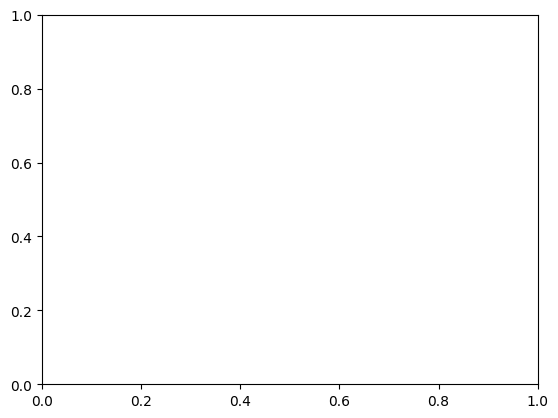

In [32]:
model.set_plotting_backend("matplotlib")
fig, ax = plt.subplots()
#model.plot(forecast, ax = Axes.set_xlim([pd.Timestamp('2022-01-01 00:00:00'),pd.Timestamp('2022-01-03 23:45:00')]))
model.plot(forecast, ax = ax)
ax.set_xlim([pd.Timestamp('2022-01-01 00:00:00'),pd.Timestamp('2022-01-03 23:45:00')])
plt.show()
